In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import thinkstats2
import thinkplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import binarize
import math


# Dealing With Imbalanced Data

Take credit card fraud, most transactions are not fraud. A few are, and it is important that those are the ones that we notice. What do we do?

The <b>Class</b> varaible is the target, the other stuff is all of the things we know about each transaction. We can effectively think of these things as "things that Mastercard knows" about each transaction - store the puchase was at, was the card swiped, tapped, or inserted, was this transaction in the same city as the last one, time of day, etc... 

<b>Note:</b> The data here is real, from MasterCard, the weird values is because the data was put through something called PCA before being shared with the public. PCA is a way to reduce the dimensionality (reduce number of features), it also renders the results unrecognizable - here it has been done so that the CC company doesn't share any private stuff. We will look at PCA during the ML stuff, for now we can consider it similarly to one-hot encoding - we put the data through the transformation, and it spits out a dataset that is ready to model with, but not very readable for a human. 

In [3]:
df = pd.read_csv("data/creditcard.csv.zip")
df.sample(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
275300,166465.0,0.361979,0.298060,-0.221502,2.200993,-0.961457,0.678214,-0.060669,0.515073,-0.027739,...,0.493768,1.203740,0.665337,0.579561,-1.219293,-0.339988,0.048317,0.036103,182.00,0
177085,123031.0,-0.395464,0.774166,1.763941,-0.355553,0.004153,-0.334603,0.558717,-0.035273,0.048160,...,-0.093251,-0.138871,-0.073433,-0.016907,-0.297550,-0.531769,0.167585,0.150226,14.98,0
73330,55086.0,1.178465,0.454435,-0.395858,0.723147,0.135736,-0.750605,0.170761,-0.003811,-0.326875,...,-0.053683,-0.136652,-0.028205,0.117519,0.416744,0.370753,-0.025778,0.023568,0.76,0
137670,82272.0,0.610199,-0.983635,-0.151872,-0.294897,-0.938216,-0.832820,0.156239,-0.135491,1.430521,...,0.166996,0.108559,-0.321202,0.346272,0.461009,-0.649011,0.048673,0.105820,304.98,0
135903,81453.0,-2.530061,1.853705,-0.422732,1.167268,-1.564278,-1.215683,-0.639788,1.467554,-0.694658,...,0.320015,0.336759,0.058705,0.692631,-0.252594,-0.377872,-0.600552,-0.067303,32.52,0
245117,152610.0,1.823514,1.048840,-1.194745,4.101450,0.881158,0.145872,-0.093097,0.096399,-0.822138,...,-0.400815,-1.149478,0.405051,0.265824,-0.523727,-0.449407,0.044500,0.054297,24.94,0
201897,134082.0,2.026075,-0.174405,-1.199911,0.224753,0.047758,-0.629328,0.023743,-0.107385,0.394531,...,-0.258041,-0.675280,0.297935,-0.411991,-0.321662,0.205617,-0.076484,-0.074669,5.49,0
124065,77164.0,1.251999,-1.297013,-0.117593,-2.778734,-1.026826,-0.293690,-0.619814,-0.100399,1.088261,...,-0.318973,-0.284918,-0.212449,-0.744982,0.650763,-0.663886,0.111461,0.035874,99.62,0
140986,84068.0,-1.036336,0.445716,-0.305960,0.362895,2.524909,3.633957,-0.409486,1.385943,-0.758020,...,0.004044,-0.277626,-0.211531,1.020294,0.377910,-0.208666,0.013762,-0.033729,26.54,0
105199,69404.0,1.260451,-0.667841,0.171875,-0.732391,-0.904555,-0.582115,-0.399662,-0.091687,-1.134462,...,-0.529924,-1.264964,0.094897,0.004162,0.030253,0.802426,-0.077487,0.007541,67.90,0


### Look at the Target's Distribution

Most things are legitimate transactions, a few of those are frauds. What is the breakdown? 

In [4]:
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Fraud is a 1 in the class value - there is not much fraud! We could be REALLY accurate if we made a dumb model...

0.9982725143693799


<AxesSubplot:xlabel='Class', ylabel='count'>

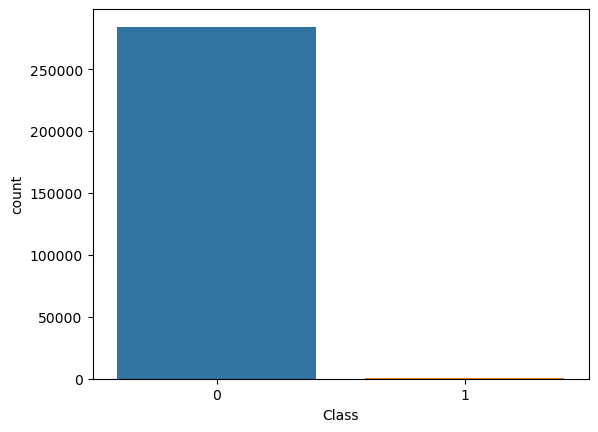

In [5]:
print(len(df[df["Class"]==0])/len(df))
sns.countplot(data=df, x="Class")

#### Target Distribution Results

If our model just guessed NO every time, we'd be 99.8% accurate - really good, but also useless for the application at hand. We'd be technically correct, which is the best kind of correct, but we would not do a great job.  

### Regular Model

First, we'll make a model without doing anything, to see the results. 

#### Exploration

We won't explore the data a tonne here, but one of the things that we'd probably want to start with would be looking to see if there is a decided difference in the distributions of all the different variables between fraudulent transactions and normal ones. If there are values that are drastically different, those are likely things that are significant in predicting fraud...

We can do a little exercise to generate a sequence of boxplots for each varaible, split by the class. 

#### SubPlots

This is the "normal" way of making a grid of visualizations. We use the plt/subplots() function to create the set of subplots and it returns two things:
<ul>
<li> The first returned value, f, is the figure - the entire graph object. 
<li> The second returned value, axes, is the "grid" of spaces. In each graph we specify, with two indicies, where that graph will be placed in the grid. It is basically a 2D array. 
</ul>

For something like this, we will try looking at boxplots rather than the normal histogram or pdf. The effect is the same, we can eyeball the general patterns of the distribution, but for this data I think the boxplots show it a bit more clearly. 

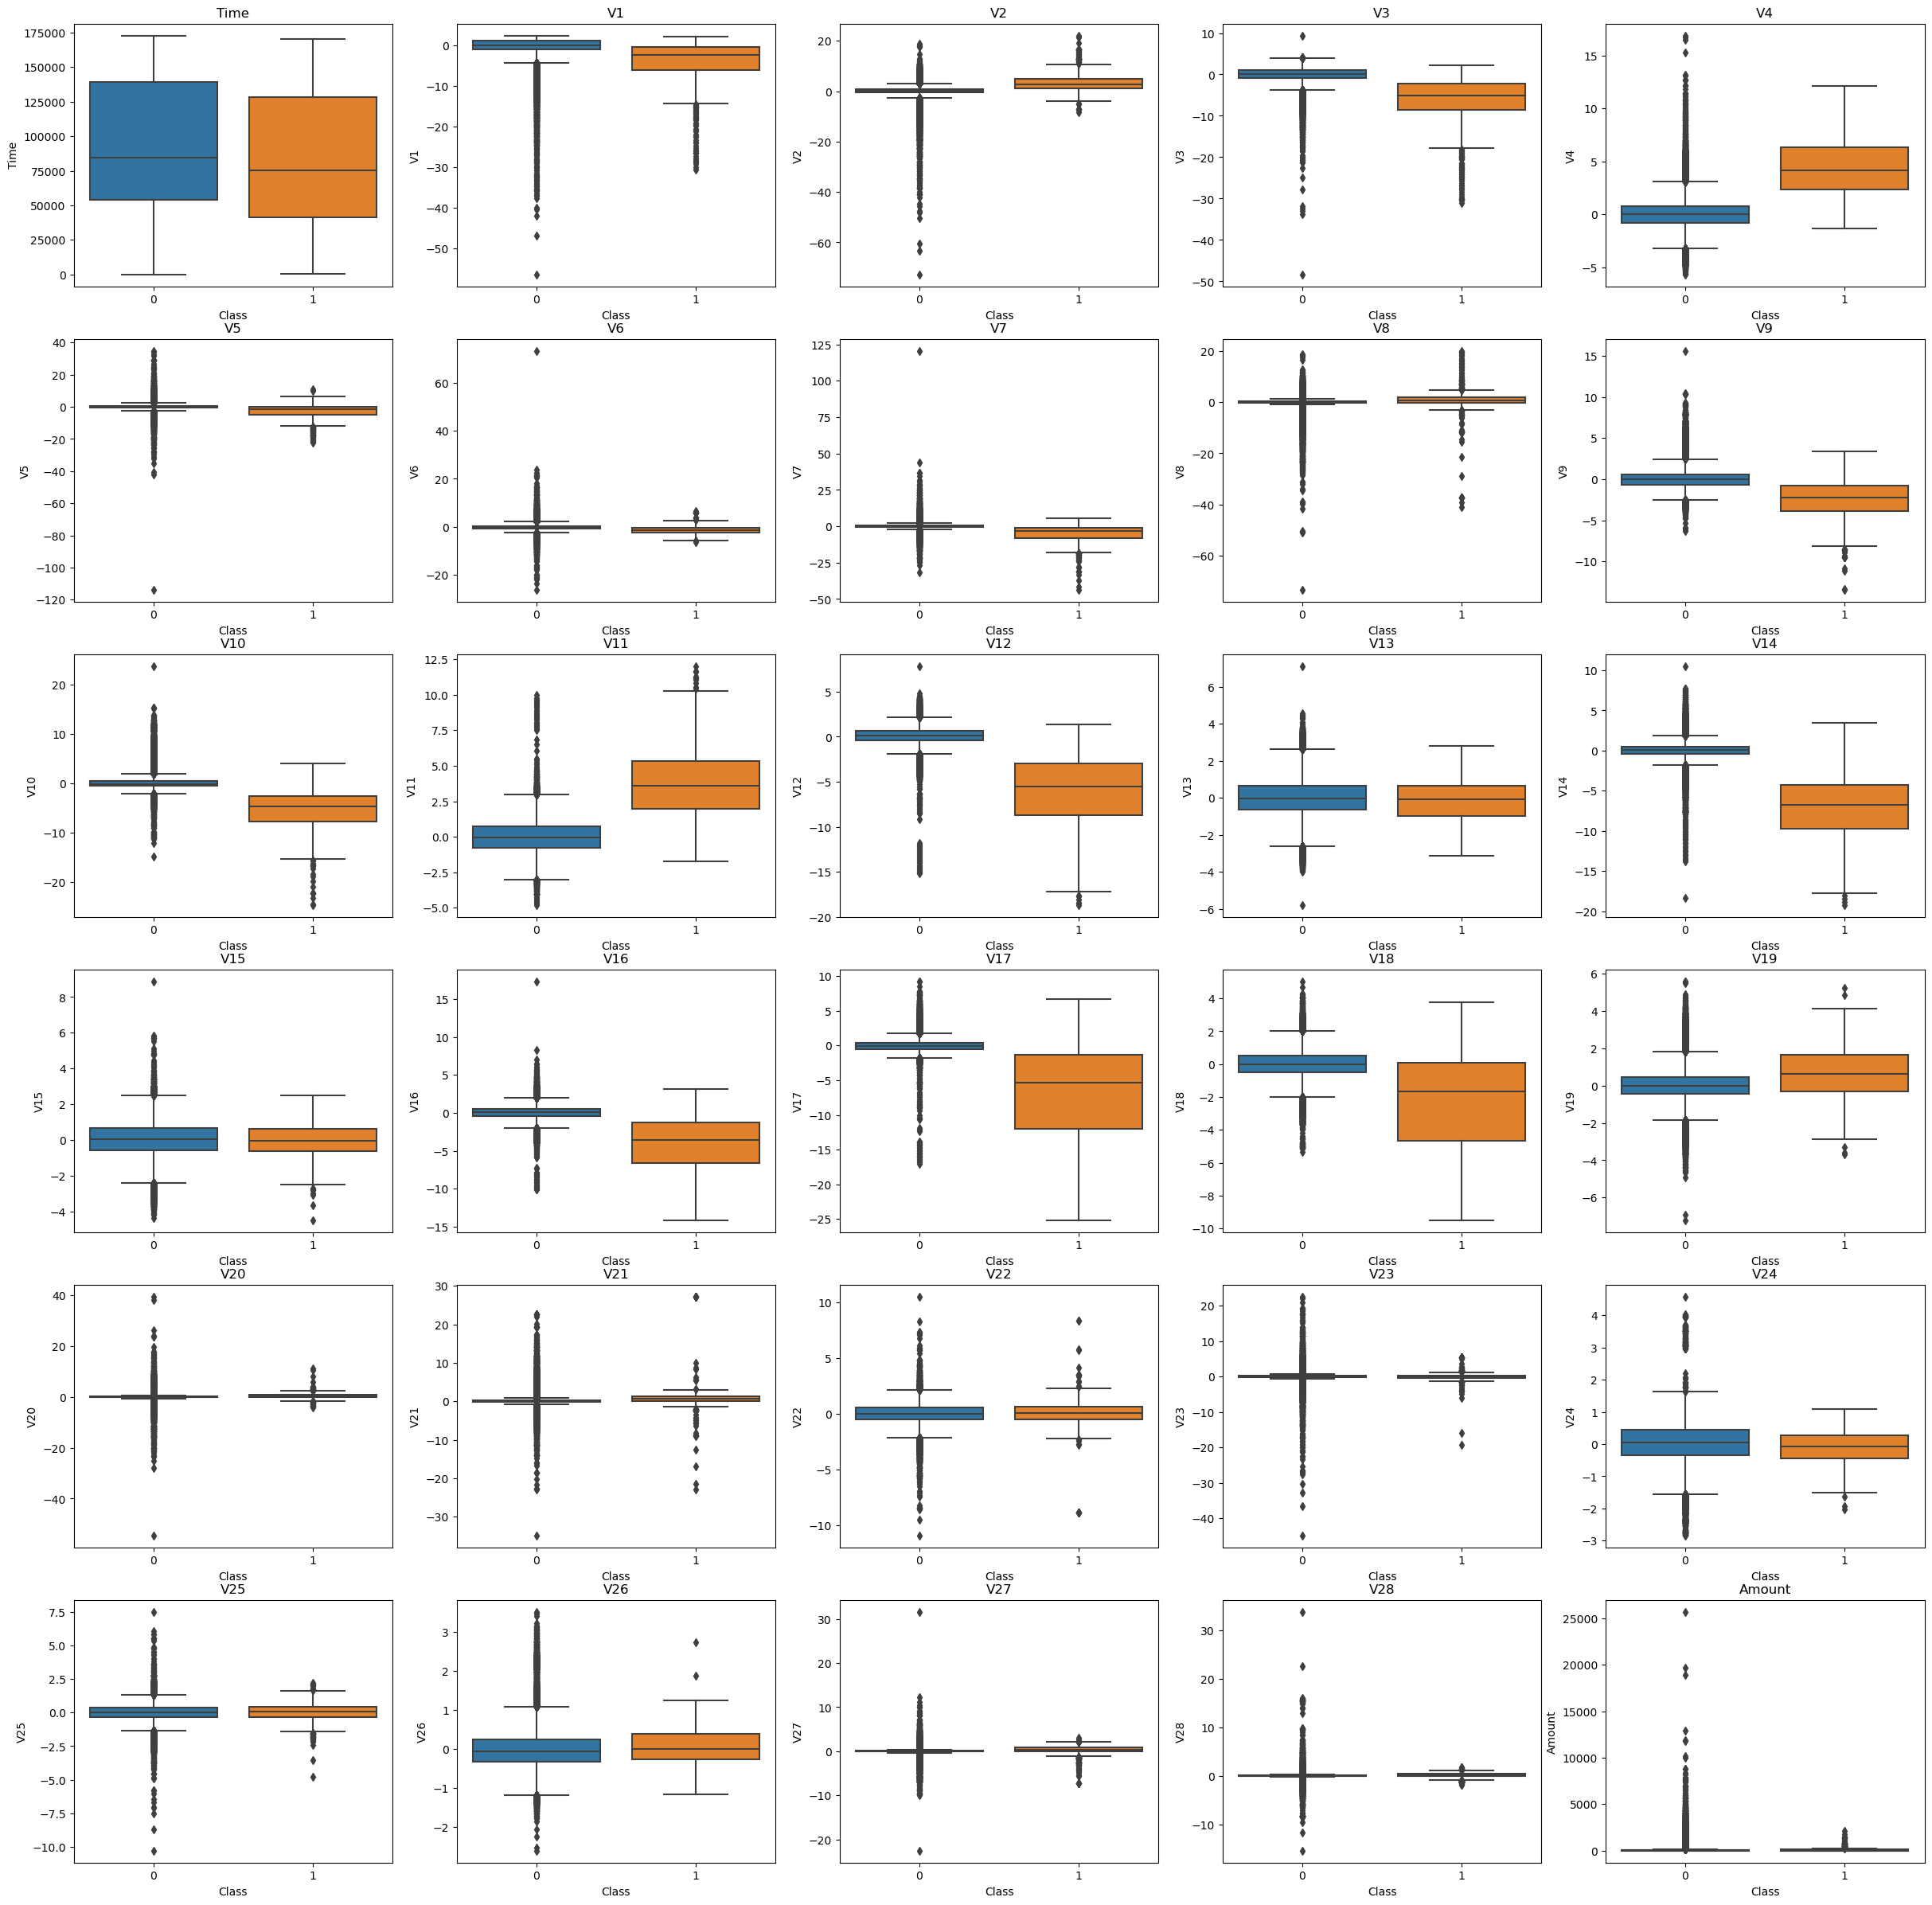

In [6]:
#Visualize differences
feats = df.drop(columns={"Class"}).columns
gCols = 5
#gRows = math.ceil( (len(feats) - 1) /gCols )
gRows = math.ceil( len(feats) /gCols )

f, axes = plt.subplots(ncols=gCols, nrows=gRows, figsize=(30,30))
i = 0
q = 0
for column in feats:
    #sns.kdeplot(data=df, x=str(column), hue="Class", ax=axes[q][i])
    sns.boxplot(x="Class", y=str(column), data=df, ax=axes[q][i])
    axes[q][i].set_title(str(column))
    i += 1
    if i >= gCols:
        i = 0
        q += 1

Some varaibles, like V13, show very little difference between fraudulent and not fraudulent transactions. Others like V14 seem to show some substantial difference between legit and fraud transactions. We can suspect that those with a difference will likely be our most relevant features in making predictions. However, this is only a suspicion - for example, combinations of varaibles might contain lots of the predictive value, and those aren't really that visible.  

First, we can builld a basic model, and see what our accuracy is without any maniplation. 

(190820, 30) (190820, 1) (93987, 30) (93987, 1)
F1: 0.6992481203007519
Acc: 0.9991488184536159
Recall: 0.5886075949367089
Precision: 0.8611111111111112


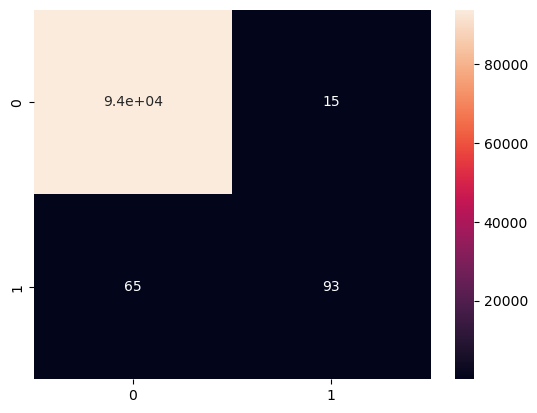

In [7]:
#Build Log Reg model
#Split Data x/y
y1 = np.array(df["Class"]).reshape(-1,1)
x1 = np.array(df.drop(columns={"Class"}))

X_train1, X_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.33)

print(X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape)
#Normalize data
scaler = MinMaxScaler()
X_train1_norm = scaler.fit_transform(X_train1)
X_test1_norm = scaler.transform(X_test1)

#Train model
model1 = LogisticRegression().fit(X_train1_norm,y_train1.ravel())

#Make predictions
preds1 = model1.predict(X_test1_norm)

#Generate 1/0 results and show results
labels1 = binarize(np.array(preds1).reshape(-1,1), threshold=.5)
conf_matrix1 = confusion_matrix(y_test1,labels1)
sns.heatmap(conf_matrix1, annot=True)

print("F1:",f1_score(y_test1, labels1))
print("Acc:",accuracy_score(y_test1, labels1))
print("Recall:",recall_score(y_test1, labels1))
print("Precision:",precision_score(y_test1, labels1))

### Simple Model Results

Overall accuracy is of course high. We do have a bunch of frauds that we are missing, however - we can try to resolve this... hopefully. We are also almost always just guessing "not fraud", which results in high accuracy, but isn't the most useful solution. What we probably want to look at more than the accuracy here is the Recall and the F1. Recall is a metric of how many frauds we are detecting, so we want it to be high. F1 is a balance of recall and precision (how many of the frauds that we detect are real), so this is also a consideration - we don't want to be accusing innocent card holders!

## Data Transformations for Imbalanced Data

We can manipulate our dataset to generate training data that is better suited to training our model. The lack of balance between the two target classes "makes it hard" for our model to learn to make reliable predictions - it wants to be accurate, and the easiest way to be accurate is to just guess "not fraud". To attempt to negate this we can just make our dataset more equal and use that to train the model. 

We are still testing against that set aside testing dataset, so our evaluation of accuracy stays constant. 

<b>Note:</b> when doing things like resampling we are obviously changing the original dataset, and making it into something it isn't. This can feel wrong, but if we step back we can see it is ok. Our goal is not to maintain an accurate set of training data, our interest is to make an accurately predicting model. If changing our data allows the model to become better, that's fine - even if the underlying data is "wrong" or altered. If you've ever trained for a sport, this is kind of similar to that - you might practice shooting a basketball with one hand, or swing a heavier baseball bat, or practice just the last little wrist-flick part of a hockey shot over and over - you're changing the "training material" (what you practice) to be something that is different from the actual sport, in order to allow that training to make the main thing you care about better. This is the same, if changed data lets the model learn, then we are OK with it. In practice, we can even generate synthetic training data, we'll look at that a bit around when we look at neural networks. 

### Undersampling and Oversampling

There are two basic approaches we can take to making the data more balanced:
<ul>
<li> Undersampling - limit the quantity of records, so all of the macjority class records are not included. 
<li> Oversampling - repeat the minority class records multiple times, so there is a balanced number. 
</ul>

![Sampling](images/sampling.png "Sampling")

Within each of these there are assorted approaches, but this is the basic idea - we make the groups more equal in count by limiting what we have a lot of, or replicating what we have a few of. 

### Undersampling

The most simple way to approach this is to undersample the not frauds - just leave a bunch out. That one kind of has a downside - we're leaving behind all that potentially valuable data!

We can create a simple undersampler and test it. We will use all the fraudulent data, and randomly select non-fraud data so that we have a balanced number of records on each side. This chops out a bunch of data, but it will give us an equal number of fraud/good, so our dumb approach of always guessing NO won't work with this data. Note that the test dataest is really large here - since our training data is limited, there's not much, if any, downside to just using the rest of the records as test data. 

(704, 30) (704, 1) (85443, 30) (85443, 1)
F1: 0.28668941979522183
Acc: 0.9926617745163442
Recall: 0.9
Precision: 0.17050067658998647


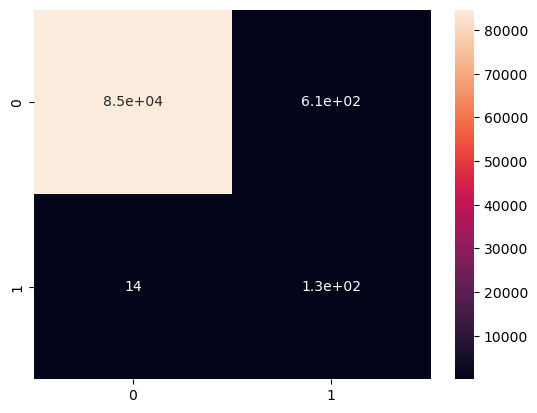

In [8]:
#Undersample
#Split the data into test train
train2, test2 = train_test_split(df, test_size=.3)
#Prep the test data by splitting x/y
y_test2 = np.array(test2["Class"]).reshape(-1,1)
X_test2 = np.array(test2.drop(columns={"Class"}))

#Manually resample the training data
df_NonFrauds = train2[train2["Class"]==0]
df_Frauds = train2[train2["Class"]==1]
df_NF = df_NonFrauds.sample(len(df_Frauds))
df_Under = pd.concat([df_NF, df_Frauds])
y_train2 = np.array(df_Under["Class"]).reshape(-1,1)
X_train2 = np.array(df_Under.drop(columns={"Class"}))
print(X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape)
#Normalize data
scaler2 = MinMaxScaler()
X_train2_norm = scaler2.fit_transform(X_train2)
X_test2_norm = scaler2.transform(X_test2) 

#Train model
model2 = LogisticRegression().fit(X_train2_norm,y_train2.ravel())

#Make predictions
preds2 = model2.predict(X_test2_norm)

#Generate 1/0 results and show results
labels2 = binarize(np.array(preds2).reshape(-1,1), threshold=.5)
conf_matrix2 = confusion_matrix(y_test2,labels2)
sns.heatmap(conf_matrix2, annot=True)

print("F1:",f1_score(y_test2, labels2))
print("Acc:",accuracy_score(y_test2, labels2))
print("Recall:",recall_score(y_test2, labels2))
print("Precision:",precision_score(y_test2, labels2))

#### Undersampling Results

Our overall accuracy is still high, but not very relevant. We have improved our Recall, so we are catching more fraud. on the downside, our precision has fallen, and we are accusing too many people of stealing unfairly! As well, we'd expect very wide variation of results for this - we're plucking out a small percentage of non-frauds and ignoring the rest; random variation will probably be significant from run to run. 

We can probably beat that, at least we hope. We can try to oversample the missing value, or include it more. 

### Oversampling

Now we can try to oversample, or duplicate the fraudulent examples in the training data until we have a balanced dataset. We will take the fraudulent records and use sampling with replacement (the records sampled are returned to the pool after they are taken), to "build up" the fraudulent part of the dataset to be the same size as the non-fraudulent ones. 

(398080, 30) (398080, 1) (85443, 30) (85443, 1)
F1: 0.13743864346273985
Acc: 0.9773767306859544
Recall: 0.9166666666666666
Precision: 0.0742884708152436


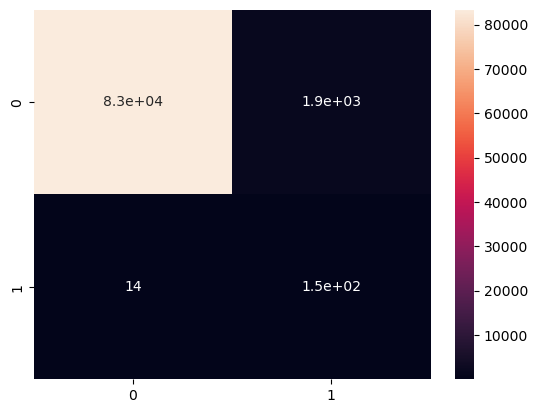

In [9]:
#Oversample
#Split the data into test train
train3, test3 = train_test_split(df, test_size=.3)
#Prep the test data by splitting x/y
y_test3 = np.array(test3["Class"]).reshape(-1,1)
X_test3 = np.array(test3.drop(columns={"Class"}))

#Manually resample the training data
df_NonFrauds = train3[train3["Class"]==0]
df_Frauds = train3[train3["Class"]==1]
df_F = df_Frauds.sample(len(df_NonFrauds), replace=True)
df_Under = pd.concat([df_NonFrauds, df_F])
y_train3 = np.array(df_Under["Class"]).reshape(-1,1)
X_train3 = np.array(df_Under.drop(columns={"Class"}))

print(X_train3.shape, y_train3.shape, X_test3.shape, y_test3.shape)
#Normalize data
scaler3 = MinMaxScaler()
X_train3_norm = scaler3.fit_transform(X_train3)
X_test3_norm = scaler3.transform(X_test3) 

#Train model
model3 = LogisticRegression(max_iter=10000).fit(X_train3_norm,y_train3.ravel())

#Make predictions
preds3 = model3.predict(X_test3_norm)

#Generate 1/0 results and show results
labels3 = binarize(np.array(preds3).reshape(-1,1), threshold=.5)
conf_matrix3 = confusion_matrix(y_test3,labels3)
sns.heatmap(conf_matrix3, annot=True)

print("F1:",f1_score(y_test3, labels3))
print("Acc:",accuracy_score(y_test3, labels3))
print("Recall:",recall_score(y_test3, labels3))
print("Precision:",precision_score(y_test3, labels3))

#### Oversample Results

Still not crushing it... Recall is good, but we're again accusing everyone of fraud! Our precision sucks. 

## More Sophisticated Sampling - With Library Functions

If we look at the above, we don't really improve accuracy, in fact we're overall worse than the dumb model. We do get somewhat better on some of the metrics, some of the time, but not really in a way that is excellent. 

We can use some more sophisticated library functions to attempt to make this better. 

<b>Note:</b> you likely need to install the imblearn package. Open a terminal, and type either "pip install imblearn" or "conda install imblearn", one of those should work. You may need to save and reopen this file to force it to update.

In [10]:
# Uncomment the row below and run to install imblearn package. 
# This assumes that you have pip, if not try "!conda install pip", then retry. 
#!pip install imblearn

In [11]:
!conda install pip

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done


In [12]:
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


In [13]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

## Resampling Functions, Decision Boundaries, and Data Generation

We can utilize these random over/under samplers to help us out and do what we did above a little bit more easily. These resampling libraries are also smarter than random in what they select - each one works differently, but they are generally looking for records that will help build a <i>discriminatory</i> model, or one that is very good at splitting true from false, or fraud from not fraud. 

In the code below there are a whole bunch of different sampling strategies. There are a lot! We have a handful in there that we can try. The over/under sampling ones are just what we did above. The others use some more involved methods to do the sampling. A few that we can try are:
<ul>
<li>SMOTE - Oversampling. Very common. Definition: "SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample as a point along that line."
<li>Tomek Links - Undersampling. Definition: "Tomek Links refers to a method for identifying pairs of nearest neighbors in a dataset that have different classes. Removing one or both of the examples in these pairs (such as the examples in the majority class) has the effect of making the decision boundary in the training dataset less noisy or ambiguous."
<li>ADASYS - Oversampling. Similar to SMOTE but it generates different number of samples depending on an estimate of the local distribution of the class to be oversampled
</ul>

In general, both oversampling and undersampling are fairly common. Common places that we may see it used is in survey types of statistics - when Stats Canada takes a survey of a few thousand people accross Canada, that is likely enough for general estimation. However, if there are demgraphic subgroups that have small numbers, analysis done with the data may oversample them to ensure that they are represented in the data. As well, very large datasets such as the ones used by Google to predict advertising use undersampling to reduce the massive amount of data. 

### Data Generation

These smart resampling aren't only doing the random slection that my simple code above did, they are (often) actually generating new data in the process. We call new data that is created for the purposes of training models, synthetic data. To understand how and why, we need to look at what classification models are attempting to do - separate True from False. Rather than just repeating the minority class over and over like I did above, they can generate variations based on that minority data. The goal here is to "bulk out" the minority class in the training data with more records that are plausible, but not real; this synthetic data should "look like" the real data as much as is possible. 

Generating training data is something that is reasonably common - in some cases it can work very well, in others we introduce error. Like many things, we'd need to see how it works with our data, and evaluate the results. 

### Decision Boundaries

<b>Notes:</b> 
<ul>
<li> For this, assume we are looking at data with 2 features only, so we can picture it. 
<li> We'll look at this in more depth when we explore more classification algorithms. 
</ul>

Our classification models, if we are to visualize them, are attempting to establish good "decision boundaries", or "lines" that can separate the two classes - things on one side are labeled True, on the other they are false. The more discriminatory this boundary is, or the better job it does are separating the two classes, the more accurate our model will be. 

To extend on this idea, what we really care about is what happens "along" that boundary, since that is where all of the edge cases sit. Consider if you had a model that classifies people into sumo wrestlers or basketball players - people who are 7'2" or people who are 400 pounds are pretty easy to put in one group or another - it is dividing the people that could go either way that really matter. Our data poses the same issue, just a bit larger and more complex. 

![Boundary](images/boundary.png "Boundary")

The sharper this line is in dividing the samples, the better our model will be. We are currently using logistic regression, which is linear, which will generate linear decision boundaries. This isn't a limitation for other types of algorithms, we can split things accurately when the boundaries are not linear, we just need some different tools that we'll look at with some of our different classification algorithms. 

#### SMOTE - Oversampling

![SMOTE](images/smote.png "SMOTE")

SMOTE generates samples that are similar to those that already exist, by creating new samples that are "in-between" the other samples. 

#### Tomek Links - Undersampling

![Tomek](images/tomek.png "Tomek")

Tomek links, or the Tomek links algorithm, looks for pairs of points along that decision boundary that are similar. The algorithm then removes the majority point from the pair (usually, there are a few options). This acts to "clean" the decision boundary between the two sets of data, and offer our logistic regression a more clear place to "draw a line" between the two sets. 

#### SMOTETomek - Combinations

![SMOTETomek](images/smotetomek.png "SMOTETomek")

These imbalanced preparation steps can also be combined. For example, one combination is the SMOTETomek algorithm, which does both of the above:
<ul>
<li> A - Original imbalanced data. 
<li> B - Use SMOTE to generate an oversampled dataset. 
<li> C - Generate "tomek links" of the similar pairs on the boundaries. 
<li> D - Use the majority removal part to delete those records from the pairs. 
<li> Result - the decision boundaries (not linear in this case, we'll deal with this in ML) are more clear. 
</ul>

#### Imbalanced Algorithms

There are several more algorithms, and combinations, in the imblearn package. Each has some different approach to this rebalancing act. The results are generally going to be highly data dependent. 

## Imbalanced Learn Trials

We can try a few sampling strategies below by just importing and creating those sampling objects. The printed statement will tell us what the balance is. More on each one, and the other options are detailed in the documentation here: https://imbalanced-learn.org/stable/index.html 

<b>Note:</b> the n_jobs argument here is something that will be repeated in random places going forwards. It tells the computer how many threads to run* while processing, the -1 tells it to do "as many as possible". For lots of things that take a long time, like training models, we can sometimes add this to make python use all of the processors on our computer, and run more quickly. 

*In short, most computers have more than one "core" in the processor, so they can literally process several things at the same time. Each one of these things is called a thread. This is generally why something can be processing on your computer, but you can still use it for other stuff - each of those things is run separately, on a separate core of the processor. Here, we are basically splitting the work into multiple threads, then sending each to the processor, and allowing them each to run in parallel, rather than in sequence. As an example, my work MacBook that I wrote this on has 4 cores, each of which can handle two threads at a time; my computer has about 6000 total "running" threads total at the moment - some from each Chrome tab, VS Code, the Mac OS, etc.... most are idle at any point in time. 

Resampled dataset shape Counter({0: 190490, 1: 190490})
F1: 0.2502202643171806
Acc: 0.9909455563003394
Recall: 0.8765432098765432
Precision: 0.1459403905447071


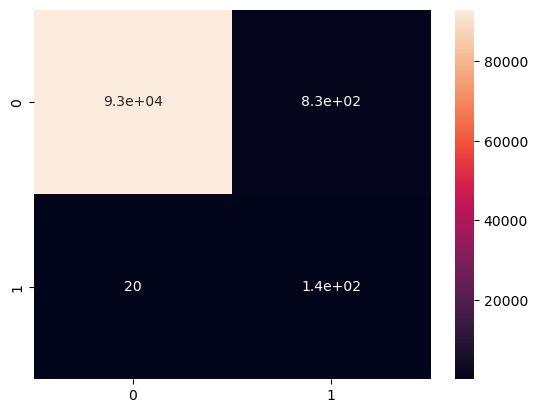

In [14]:
#Do some samplin'
#sampler = RandomOverSampler(n_jobs=-1)
#sampler = RandomUnderSampler(n_jobs=-1)
#sampler = TomekLinks(sampling_strategy='not majority', n_jobs=-1)
sampler = SMOTE(n_jobs=-1)
#sampler = ADASYN(n_jobs=-1)
#sampler = SVMSMOTE(n_jobs=-1)

#Build Log Reg model
#Split Data x/y
y4 = np.array(df["Class"]).reshape(-1,1)
x4 = np.array(df.drop(columns={"Class"}))

X_train4, X_test4, y_train4, y_test4 = train_test_split(x4, y4, test_size=0.33)

#Look at relative imbalance after split
X_train4Samp, y_train4Samp = sampler.fit_resample(X_train4, y_train4)
print('Resampled dataset shape %s' % Counter(y_train4Samp))

#Normalize data
#scaler = MinMaxScaler()
scaler = StandardScaler()
X_train4_norm = scaler.fit_transform(X_train4Samp)
X_test4_norm = scaler.transform(X_test4)

#Train model
model4 = LogisticRegression(max_iter=1000, n_jobs=-1).fit(X_train4_norm,y_train4Samp.ravel())

#Make predictions
preds4 = model4.predict(X_test4_norm)

#Generate 1/0 results and show results
labels4 = binarize(np.array(preds4).reshape(-1,1), threshold=.5)
conf_matrix4 = confusion_matrix(y_test4,labels4)
sns.heatmap(conf_matrix4, annot=True)

print("F1:",f1_score(y_test4, labels4))
print("Acc:",accuracy_score(y_test4, labels4))
print("Recall:",recall_score(y_test4, labels4))
print("Precision:",precision_score(y_test4, labels4))

### Resampling Results?

What can we learn from all of this? We were not able to really make things extremely accurate, which sucks!

Some potential issues here:
<ul>
<li>This data may not be well suited to a logistic regression model. 
<li>We may have some features that we need to remove - perhaps there are confounding varaibles. 
<li>We could layer these things together - e.g. use SMOTE then random undersampling. 
</ul>

Just for fun we'll try one with a different type of model and see what we can get. The performance of any indivdual model isn't really super easy to predict in advance - there are some applications that are better suited to some models, but it isn't super determinative. Next semester we'll look at more and more comparisons. 

#### Try Another Algorithm

Below is the same code, but we swapped out Logistic Regression with a Random Forest - which is a tree based algorithm. 

Resampled dataset shape Counter({1: 190563, 0: 190514})
F1: 0.8465909090909092
Acc: 0.9994254524561907
Recall: 0.8010752688172043
Precision: 0.8975903614457831


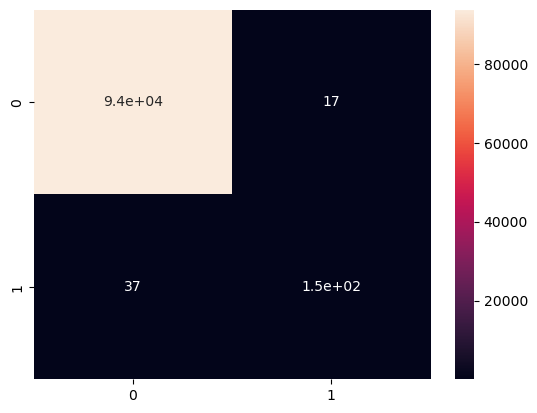

In [15]:
sampler = ADASYN(n_jobs=-1)
#Split Data x/y
y5 = np.array(df["Class"]).reshape(-1,1)
x5 = np.array(df.drop(columns={"Class"}))

X_train5, X_test5, y_train5, y_test5 = train_test_split(x5, y5, test_size=0.33)

#Look at relative imbalance after split
X_train5Samp, y_train5Samp = sampler.fit_resample(X_train5, y_train5)
print('Resampled dataset shape %s' % Counter(y_train5Samp))

#Normalize data
#scaler = MinMaxScaler()
scaler = StandardScaler()
X_train5_norm = scaler.fit_transform(X_train5Samp)
X_test5_norm = scaler.transform(X_test5)

#Train model
model5 = RandomForestClassifier(n_jobs=-1).fit(X_train5_norm,y_train5Samp.ravel())
#Make predictions
preds5 = model5.predict(X_test5_norm)

#Generate 1/0 results and show results
labels5 = binarize(np.array(preds5).reshape(-1,1), threshold=.5)
conf_matrix5 = confusion_matrix(y_test5,labels5)
sns.heatmap(conf_matrix5, annot=True)

print("F1:",f1_score(y_test5, labels5))
print("Acc:",accuracy_score(y_test5, labels5))
print("Recall:",recall_score(y_test5, labels5))
print("Precision:",precision_score(y_test5, labels5))

## Finally!!!

Of all the things we tested, only swapping to a different algorithm really gave results that are bang on! Note that the raw accuracy isn't really different from the first try, but the other considerations for accuracy are better!

Based on this, we can probably make a reasonable assumption that the logistic regression algorithm just isn't all that well suited to the data. I would suspect that the relationships that allow us to make predictions are at least partially non-linear. This kind of variability between different models isn't particularly odd - as we improve things (more data, cleaner data, no outliers etc...) they will tend to converge as some of those data cleanup things can have dramatic effects on different types of models. The true answer for "which model to use" is almost always determined by a trial. 

Lastly on this part, we can see that the mechanics of building models is <i>mostly</i> the same for us. The math behind the scences that generates the models are totally different, but using them is nearly interchangable. 

## Exercise - Try it With Insurance Data

The value Response is the goal, and it is also not balanced. We also have a few categorical varaibles (read the data carefully), so we need a little data prep as well. 

In [16]:
df2_ = pd.read_csv("data/aug_train.csv.zip")
df2_.drop(columns={"id"}, inplace=True)
df2_.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


<AxesSubplot:xlabel='Response', ylabel='count'>

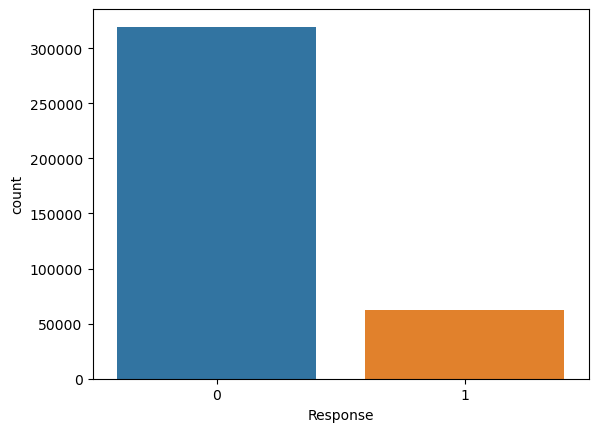

In [17]:
sns.countplot(data=df2_, x="Response")

In [18]:
df2_.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [19]:
df2_[["Gender", "Driving_License", "Previously_Insured", "Vehicle_Age", "Vehicle_Damage"]] = df2_[["Gender", "Driving_License", "Previously_Insured", "Vehicle_Age", "Vehicle_Damage"]].astype("category")
df2_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Gender                382154 non-null  category
 1   Age                   382154 non-null  int64   
 2   Driving_License       382154 non-null  category
 3   Region_Code           382154 non-null  float64 
 4   Previously_Insured    382154 non-null  category
 5   Vehicle_Age           382154 non-null  category
 6   Vehicle_Damage        382154 non-null  category
 7   Annual_Premium        382154 non-null  float64 
 8   Policy_Sales_Channel  382154 non-null  float64 
 9   Vintage               382154 non-null  int64   
 10  Response              382154 non-null  int64   
dtypes: category(5), float64(3), int64(3)
memory usage: 19.3 MB


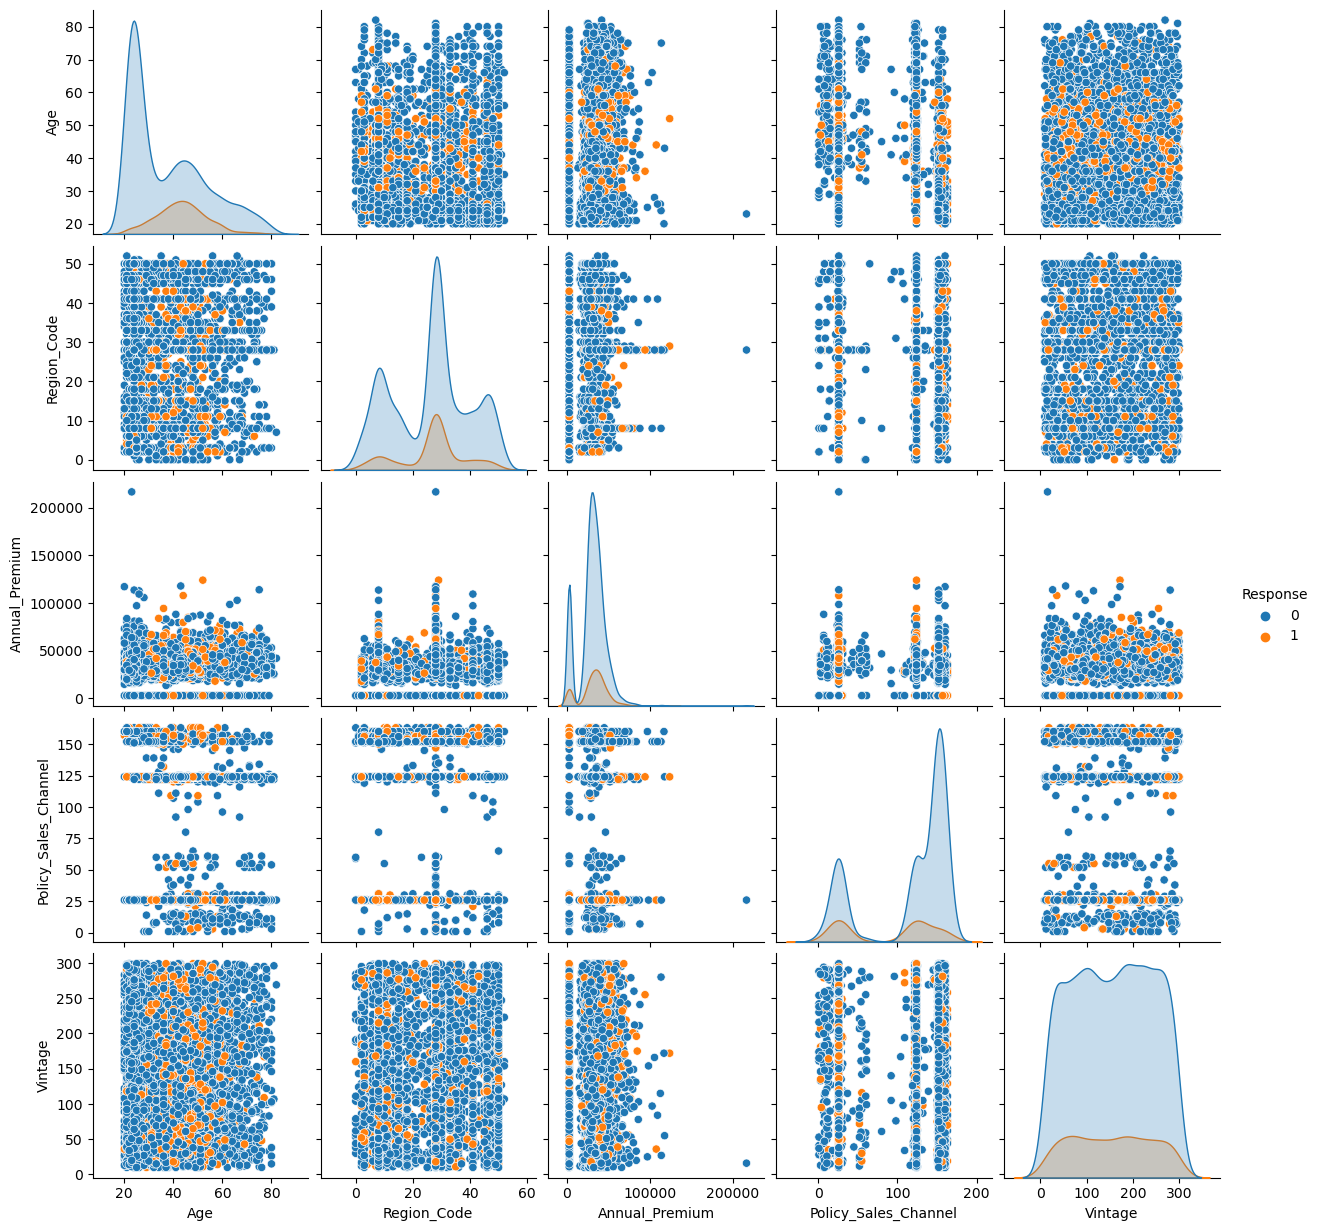

In [20]:
sns.pairplot(df2_.sample(5000), hue="Response")

##### Make Dummies

In [21]:
df2 = pd.get_dummies(df2_)
df2.sample(10)

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Female,Gender_Male,Driving_License_0,Driving_License_1,Previously_Insured_0,Previously_Insured_1,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes
103331,29,8.0,28016.0,152.0,246,0,0,1,0,1,0,1,0,1,0,1,0
68266,27,11.0,22946.0,152.0,152,0,1,0,0,1,0,1,0,1,0,1,0
288598,29,29.0,29073.0,152.0,160,0,0,1,0,1,0,1,0,1,0,1,0
191111,36,38.0,31587.0,124.0,158,0,0,1,0,1,0,1,1,0,0,1,0
273773,21,18.0,30435.0,152.0,172,0,1,0,0,1,0,1,0,1,0,1,0
188159,30,6.0,2630.0,156.0,253,1,1,0,0,1,1,0,1,0,0,0,1
237230,23,41.0,57583.0,163.0,72,0,0,1,0,1,1,0,0,1,0,0,1
151991,24,15.0,38037.0,152.0,265,0,1,0,0,1,0,1,0,1,0,1,0
291035,52,45.0,2630.0,26.0,114,1,0,1,0,1,1,0,1,0,0,0,1
149156,60,38.0,2630.0,26.0,14,0,0,1,0,1,1,0,1,0,0,0,1


##### Remove Some Outliers

In [22]:
df2 = df2[df2["Annual_Premium"] < 175000]

##### Model

Resampled dataset shape Counter({1: 218616, 0: 214089})
F1: 0.5171342046541281
Acc: 0.7116272428727809
Recall: 0.9398899188876014
Precision: 0.3566952506596306


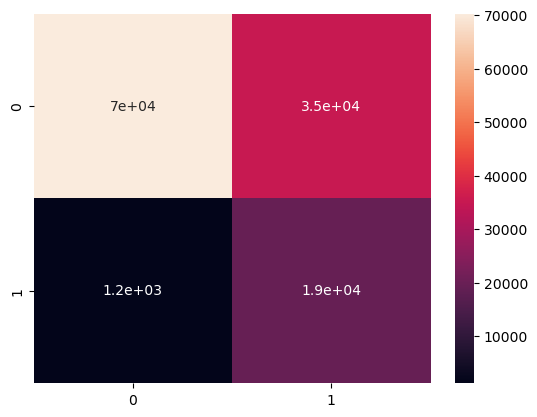

In [23]:
sampler = ADASYN(n_jobs=-1)

#Split Data x/y
y6 = np.array(df2["Response"]).reshape(-1,1)
x6 = np.array(df2.drop(columns={"Response"}))

X_train6, X_test6, y_train6, y_test6 = train_test_split(x6, y6, test_size=0.33)

#Look at relative imbalance after split
X_train6Samp, y_train6Samp = sampler.fit_resample(X_train6, y_train6)
print('Resampled dataset shape %s' % Counter(y_train6Samp))

#Normalize data
#scaler = MinMaxScaler()
scaler = StandardScaler()
X_train6_norm = scaler.fit_transform(X_train6Samp)
X_test6_norm = scaler.transform(X_test6)

#Train model
model6 = LogisticRegression(n_jobs=-1).fit(X_train6_norm,y_train6Samp.ravel())
#Make predictions
preds6 = model6.predict(X_test6_norm)

#Generate 1/0 results and show results
labels6 = binarize(np.array(preds6).reshape(-1,1), threshold=.5)
conf_matrix6 = confusion_matrix(y_test6,labels6)
sns.heatmap(conf_matrix6, annot=True)

print("F1:",f1_score(y_test6, labels6))
print("Acc:",accuracy_score(y_test6, labels6))
print("Recall:",recall_score(y_test6, labels6))
print("Precision:",precision_score(y_test6, labels6))